<a href="https://colab.research.google.com/github/harshita23sharma/Colab_Notebooks/blob/master/TransferLearning_102Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf


print(tf.__version__)
from tensorflow import keras



TensorFlow 2.x selected.
2.0.0


* Dataset link http://www.robots.ox.ac.uk/~vgg/data/flowers/102/*

## Loading the TF_FLOWERS dataset


*### **REF** : https://www.back-prop.com/deep_learning/inceptionv3/tf_flowers/feature_extraction/fine_tuning/google_colab/2019/05/17/InceptionV3_TFFLOWERS/*

`The tf_flowers dataset is not partitioned into train, test and validation by default.

To do that we can use the **tfds.Split.TRAIN.subsplit** function.

This expects a tuple indicating the split ratio like so (8,1,1). 

This splits the data into 80%, 10% and 10% ratio for train, validation and test sets.`

In [0]:
import tensorflow_datasets as tfds

SPLIT_WEIGHTS = (8,1,1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

### Downloading dataset with tfds

We can use **tfds.load()** function to load the dataset and split it as well. 
the load function has the following options.


tfds.load(
    name,
    split=None,
    data_dir=None,
    batch_size=1,
    download=True,
    as_supervised=False,
    with_info=False,
    builder_kwargs=None,
    download_and_prepare_kwargs=None,
    as_dataset_kwargs=None,
    try_gcs=False
)

*with_info=True* gives us the metadata about the dataset

*as_supervised=True* returns the data and label as a tuple (input, label)

<!-- #We can use tfds.load() function to load the dataset and split it as well. 
# the load function has the following options.


# tfds.load(
#     name,
#     split=None,
#     data_dir=None,
#     batch_size=1,
#     download=True,
#     as_supervised=False,
#     with_info=False,
#     builder_kwargs=None,
#     download_and_prepare_kwargs=None,
#     as_dataset_kwargs=None,
#     try_gcs=False
# )

# with_info=True gives us the metadata about the dataset

# as_supervised=True returns the data and label as a tuple (input, label) -->

In [0]:
(raw_train,raw_val,raw_test),metadata = tfds.load('tf_flowers',
                                                 split=list(splits),
                                                 data_dir="102flowers",
                                                  download=True,
                                                 as_supervised=True,
                                                 with_info=True)

### Build your Pipeline

In [0]:
def resize_normalize(image,label):
  
  image = tf.cast(image,tf.float32)
  
  image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
  
  image = image / 255.0
  
  return image,label

def augment(image, label):
  
  image = tf.image.random_flip_left_right(image)
  
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  
  return image,label

In [0]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

train = raw_train.map(resize_normalize)
val = raw_val.map(resize_normalize)
test = raw_test.map(resize_normalize)

train = train.map(augment)


In [0]:
SHUFFLE_BUFFER_SIZE = 1024
BATCH_SIZE = 32

train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val = val.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)


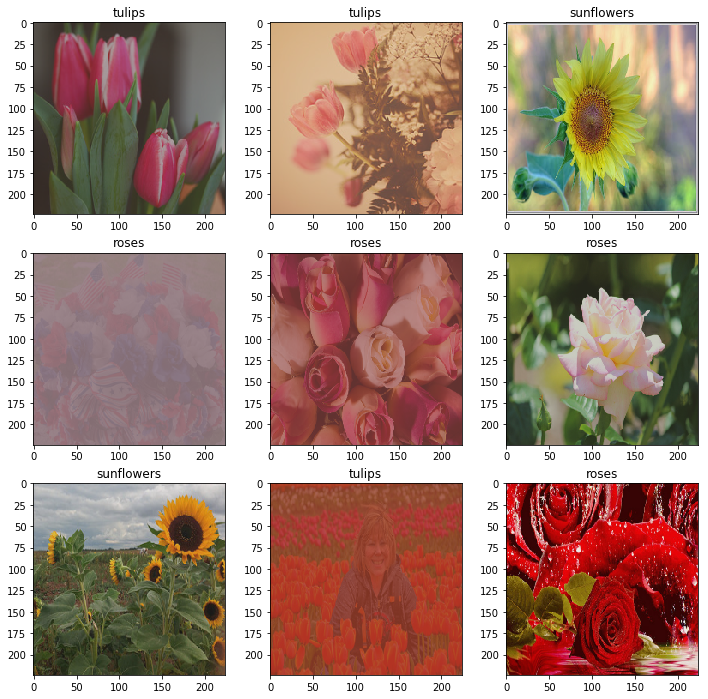

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

get_label_name = metadata.features['label'].int2str

plt.figure(figsize=(12,12)) 
for btch in train.take(1):
  for i in range(9):
    img,lbl = btch[0][i],btch[1][i]
    plt.subplot(3,3,i+1)
    plt.title(get_label_name(lbl.numpy()))
    plt.imshow(img)
plt.show()

In [8]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=1.0.0,
    description='A large set of images of flowers',
    urls=['http://download.tensorflow.org/example_images/flower_photos.tgz'],
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

#### tfds.load is faster than tensorflow.keras.preprocessing (ImageDataGenerator)



In [0]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

# TRAIN_DIR= './flower_data/train/'
# VAL_DIR= './flower_data/val/'

# train_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input)
# train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
#                                                     target_size=(HEIGHT,WIDTH),
#                                                    batch_size=BATCH_SIZE)

# valid_datagen = ImageDataGenerator(
#     preprocessing_function=preprocess_input)
# valid_generator = valid_datagen.flow_from_directory(VAL_DIR,
#                                                    target_size=(HEIGHT,WIDTH))

### Loading pretrained DenseNet121 model from keras
keras.application object comes with several pretrained models.

In [10]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
HEIGHT=224
WIDTH=224
BATCH_SIZE=32

basemodel = DenseNet121(weights='imagenet',
                        include_top=False,
                       input_shape=(HEIGHT,WIDTH,3))
basemodel.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
  for layer in base_model.layers:
    layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    
    for fc in fc_layers:
      x = Dense(fc, activation='relu')(x)
      x = Dropout(dropout)(x)
      
      # New Softmax layer
      predictions = Dense(num_classes, activation='softmax')(x)
      finetune_model = Model(inputs=base_model.input, outputs= predictions)
      return finetune_model
    
FC_LAYERS = [1024,256]
dropout =0.5
    

In [0]:
finetune_model = build_finetune_model(base_model=basemodel, dropout=dropout, fc_layers=FC_LAYERS, num_classes=102)

In [0]:
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint
NUM_EPOCHS = 20

# # num_train_images = 

adam =  SGD(learning_rate=0.0007)
finetune_model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# filepath = './Densenet121.h5'
# checkpoint = ModelCheckpoint(filepath=filepath, monitor=["acc"], verbose=1, mode="max")
# callback_list = [checkpoint]


In [14]:
ll logs/*

total 12
drwxr-xr-x 2 root 4096 Oct 19 14:15 20191019-141558/
drwxr-xr-x 3 root 4096 Oct 19 14:18 20191019-141801/
drwxr-xr-x 4 root 4096 Oct 19 14:21 20191019-141904/


In [15]:
import datetime, os

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=10)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        'Densenet121_training_checkpoints_v2/weights.{epoch:02d}-{val_loss:.2f}.hdf5', period=5)
os.makedirs('Densenet121_training_checkpoints_v2/', exist_ok=True)
early_stopping_checkpoint = keras.callbacks.EarlyStopping(patience=20)


In [16]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples * weight/10 for weight in SPLIT_WEIGHTS
)

steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = round(num_val)//BATCH_SIZE

print('Number of examples in the train set:', num_train)
print('Number of examples in the validation set:', num_val)
print('Number of examples in the test set:', num_test)

Number of examples in the train set: 2936.0
Number of examples in the validation set: 367.0
Number of examples in the test set: 367.0


In [17]:
# history = finetune_model.fit()
history = finetune_model.fit(train.repeat(),
#                              fine_tune_batch_norm = False,
              epochs=NUM_EPOCHS, 
              steps_per_epoch=steps_per_epoch,
              validation_data=val.repeat(),
              validation_steps=validation_steps,
              callbacks=[
                  tensorboard_callback,
                         model_checkpoint_callback,
                         early_stopping_checkpoint])

Train for 91 steps, validate for 11 steps
Epoch 1/20
 1/91 [..............................] - ETA: 42:19 - loss: 7.3207 - accuracy: 0.0000e+00WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (6.645582). Check your callbacks.


91/91 [==============================] - 139s 2s/step - loss: 13.0945 - accuracy: 0.4361 - val_loss: 1657036.2159 - val_accuracy: 0.1562
Epoch 2/20
91/91 [==============================] - 96s 1s/step - loss: 3.8119 - accuracy: 0.3552 - val_loss: 184.1411 - val_accuracy: 0.3267
Epoch 3/20
91/91 [==============================] - 93s 1s/step - loss: 1.4572 - accuracy: 0.4331 - val_loss: 1.4040 - val_accuracy: 0.5455
Epoch 4/20
91/91 [==============================] - 93s 1s/step - loss: 1.1654 - accuracy: 0.5177 - val_loss: 1.0220 - val_accuracy: 0.6676
Epoch 5/20
91/91 [==============================] - 97s 1s/step - loss: 1.1222 - accuracy: 0.5648 - val_loss: 0.8678 - val_accuracy: 0.6591
Epoch 6/20
91/91 [==============================] - 93s 1s/step - loss: 1.0508 - accuracy: 0.5963 - val_loss: 0.7824 - val_accuracy: 0.7188
Epoch 7/20
91/91 [==============================] - 93s 1s/step - loss: 1.0146 - accuracy: 0.6147 - val_loss: 0.6805 - val_accuracy: 0.7869
Epoch 8/20
91/91 [===

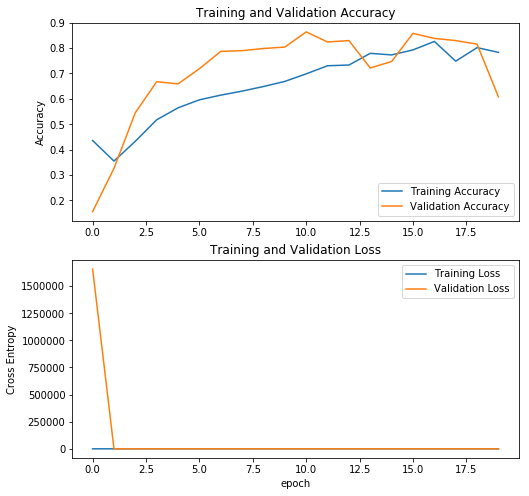

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Checking model on test data

In [0]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()


In [0]:
@tf.function
def test_step(images, labels):
  predictions = finetune_model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [59]:
for test_images, test_labels in test.take(200):
  test_step(test_images, test_labels)
  template = 'Epoch {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        test_loss.result(),
                        test_accuracy.result()*100
                       ))

Epoch 1, Test Loss: 21.18326187133789, Test Accuracy: 61.3845100402832
Epoch 1, Test Loss: 21.180023193359375, Test Accuracy: 61.388755798339844
Epoch 1, Test Loss: 21.17868995666504, Test Accuracy: 61.386322021484375
Epoch 1, Test Loss: 21.184890747070312, Test Accuracy: 61.38522720336914
Epoch 1, Test Loss: 21.187904357910156, Test Accuracy: 61.38679885864258
Epoch 1, Test Loss: 21.18691062927246, Test Accuracy: 61.38370132446289
Epoch 1, Test Loss: 21.18787956237793, Test Accuracy: 61.38393783569336
Epoch 1, Test Loss: 21.189067840576172, Test Accuracy: 61.38351058959961
Epoch 1, Test Loss: 21.186975479125977, Test Accuracy: 61.38374710083008
Epoch 1, Test Loss: 21.183347702026367, Test Accuracy: 61.38532257080078
Epoch 1, Test Loss: 21.186370849609375, Test Accuracy: 61.384891510009766
Epoch 1, Test Loss: 21.185213088989258, Test Accuracy: 61.384952545166016


In [0]:
# EPOCHS = 2

# for epoch in range(EPOCHS):
#   for test_images, test_labels in test.take(100):
#     test_step(test_images, test_labels)
#     template = 'Epoch {}, Test Loss: {}, Test Accuracy: {}'
#     print(template.format(epoch+1,
#                           test_loss.result(),
#                           test_accuracy.result()*100
#                          ))
#   # Reset the metrics for the next epoch
#   test_loss.reset_states()
#   test_accuracy.reset_states()